In [1]:
import os
import pickle
import numpy as np

import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

# load `SpenderQ` models

In [3]:
niter = 3

models = [] 
for imodel in range(1): 
    # load model
    #_models, losses = load_model('/tigress/chhahn/spender_qso/models/london.lfsc.rsnr.sa1p5sb1p5.i%i.pt' % niter)
    _models, losses = load_model('/tigress/chhahn/spender_qso/models/london.lfsc.rsnr.sa1p1sb0p8.i%i.pt' % niter)
    models.append(_models[0])

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [4]:
spec, w, z, target_id, norm = [], [], [], [], []
true_cont = [] 
recons = [] 

for ibatch in range(5): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
        _spec, _w, _z, _target_id, _norm, zerr = pickle.load(f)
    spec.append(np.array(_spec))
    w.append(np.array(_w))
    z.append(np.array(_z))
    target_id.append(np.array(_target_id))    
    norm.append(np.array(_norm))

    # load true continuum
    true_cont.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch)))

    # load SpenderQ recon 
    _recons = []  
    for imodel in range(5): 
        _recons.append(np.load('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.recons.npy' % (niter, imodel, ibatch)))
    recons.append(np.array(_recons))
    
spec = np.concatenate(spec, axis=0)
w = np.concatenate(w)
z = np.concatenate(z)
target_id = np.concatenate(target_id)
norm = np.concatenate(norm)

true_cont = np.concatenate(true_cont, axis=0)

recons = np.concatenate(recons, axis=1)

mean_recon = np.mean(recons, axis=0) # ensemble reconstruction

w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)    

In [12]:
# continuum residual over full wavelength
wave_rest_rebin = np.linspace(800, 3000, 2000)

dcont_recon, dfcont_recon = [], []
for igal in range(len(z)): 
    wlim = (wave_rest_rebin > 3.6e3/float(1+z[igal])) & ((wave_rest_rebin < 9.9e3/float(1+z[igal])))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    # rebin reconstruction
    recon_rebin = U.trapz_rebin(
        w_recon, 
        mean_recon[igal], 
        xnew=wave_rest_rebin[wlim])
    
    # residual
    dcont = np.repeat(-999., len(wave_rest_rebin))
    dcont[wlim] = true_rebin - recon_rebin 
    
    # fractional residual
    dfcont = np.repeat(-999., len(wave_rest_rebin))
    dfcont[wlim] = (true_rebin - recon_rebin)/true_rebin

    dcont_recon.append(dcont)
    dfcont_recon.append(dfcont)
    
dcont_recon = np.array(dcont_recon)
dfcont_recon = np.array(dfcont_recon)

In [13]:
# spenderq performance on QSO with picca 
dcont_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.)

    if np.sum(has_spectra): 
        dcont_q[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])     

Text(0.5, 0, 'rest-frame wavelength')

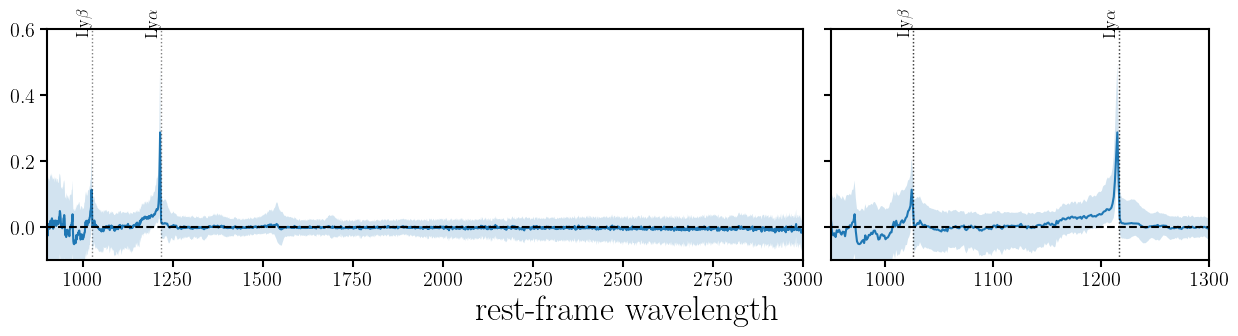

In [42]:
fig = plt.figure(figsize=(15,3))

gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

sub = plt.subplot(gs[0])

#sub.fill_between(wave_rest_rebin, dfcont_q[:,0], dfcont_q[:,4], color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], color='C0', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.66, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.66, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(900., 3000.)
sub.set_ylim(-0.1, 0.6)
#sub.set_yticklabels([])

# fractional residual
sub = plt.subplot(gs[1])

# SpenderQ
sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.66, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.66, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
#sub.set_xticklabels([])
sub.set_ylim(-0.1, 0.6)
sub.set_yticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel('rest-frame wavelength', fontsize=25)

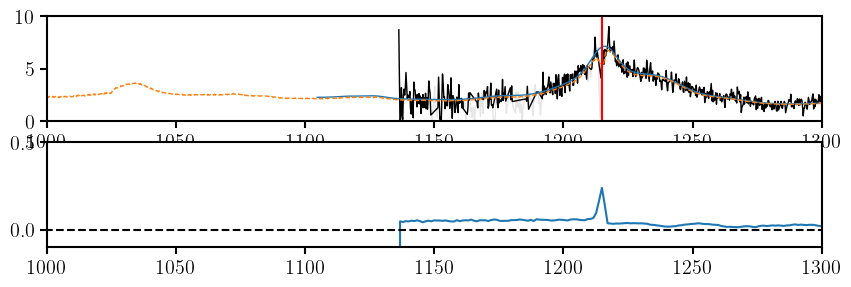

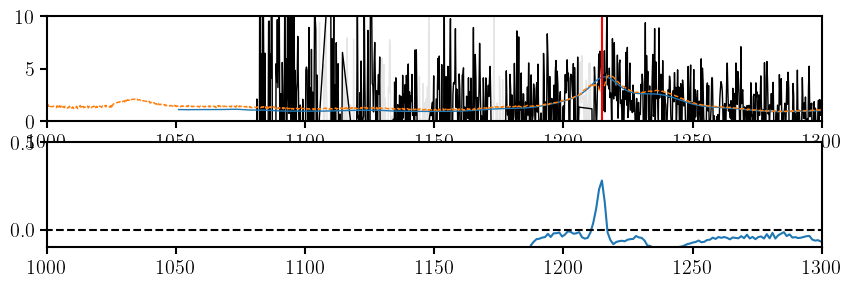

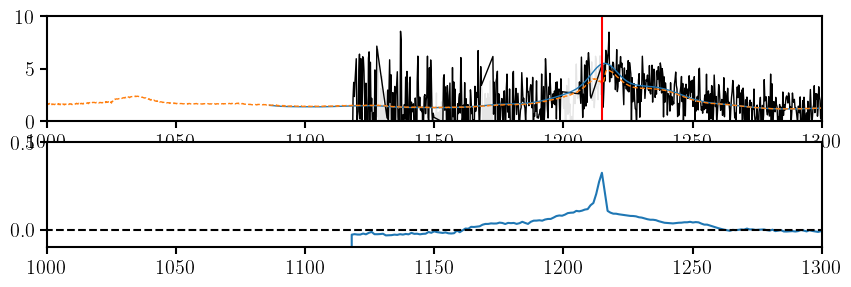

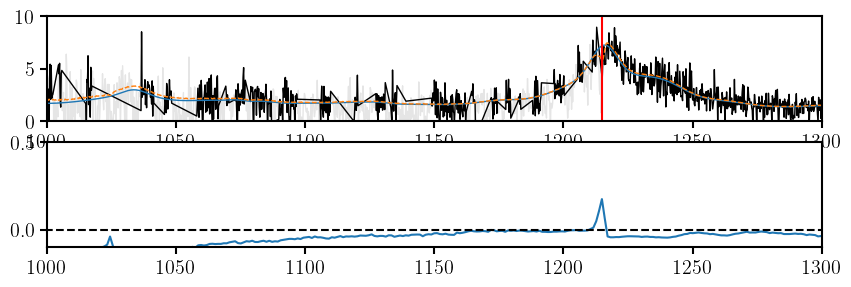

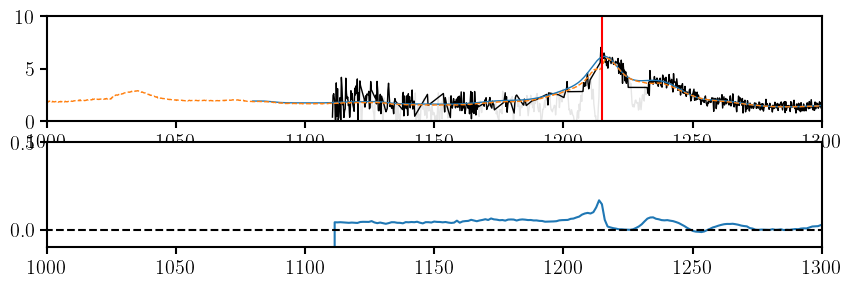

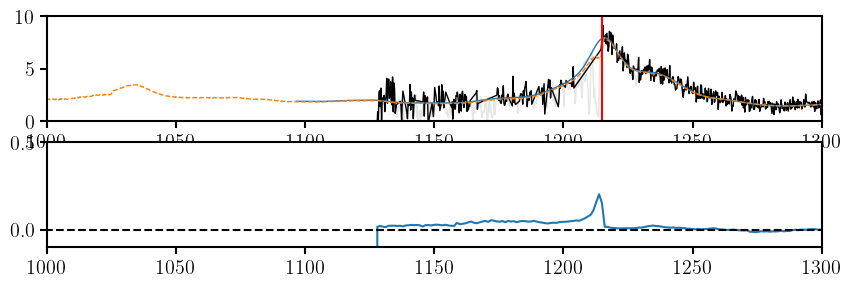

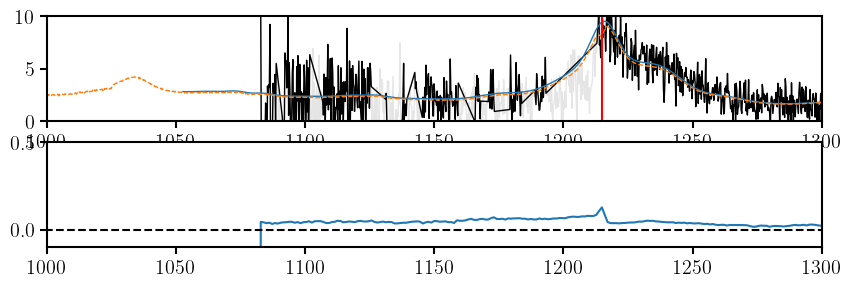

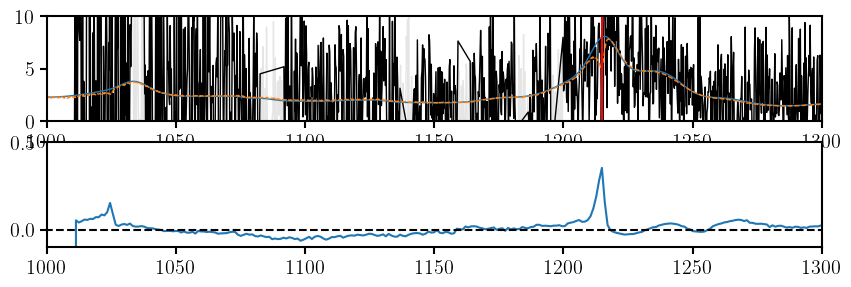

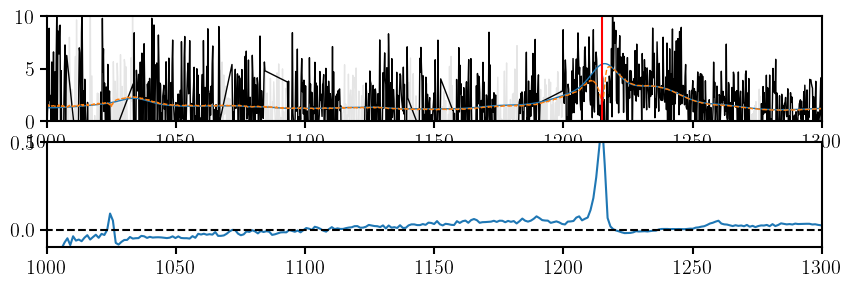

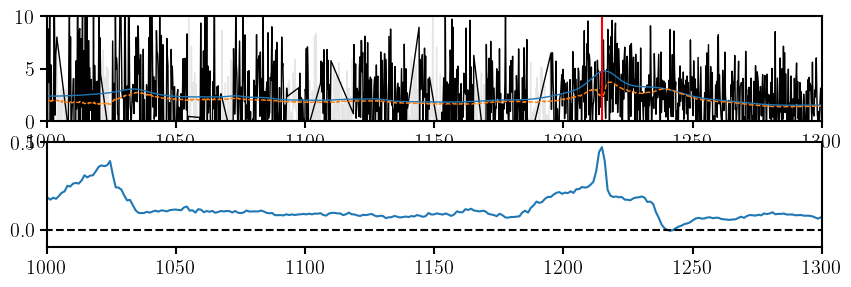

In [44]:
for igal in np.random.choice(np.arange(len(z)), replace=False, size=10):
    fig = plt.figure(figsize=(10,3))
    sub = fig.add_subplot(211)
    sub.plot(np.array(models[0].wave_obs)/(1.+np.array(z)[igal]), spec[igal], c='k', alpha=0.1, lw=1)
    wlim = np.array(w)[igal] > 0
    sub.plot((np.array(models[0].wave_obs)/(1.+np.array(z)[igal]))[wlim], spec[igal][wlim], c='k', lw=1)
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1.+np.array(z)[igal]), true_cont[igal]/np.array(norm)[igal], c='C0', lw=1)
    sub.plot(np.array(models[0].wave_rest), np.mean(recons[:,igal,:], axis=0), c='C1', lw=1, ls='--')
    sub.axvline(1215., color='r')
    
    sub.set_xlim(1000, 1300)
    sub.set_ylim(0., 10.)
    sub = fig.add_subplot(212)
    sub.plot(wave_rest_rebin, dfcont_recon[igal])
    sub.plot(wave_rest_rebin, np.repeat(0., len(wave_rest_rebin)), c='k', ls='--')
    sub.set_xlim(1000, 1300)
    sub.set_ylim(-0.1, 0.5)